In [1]:
# 標準ライブラリ
import os

# サードパーティ製ライブラリ
import matplotlib.pyplot as plt
#import paretoset

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
from pandas.plotting import parallel_coordinates
import numpy as np

import math
import pandas as pd
#import paretoset


# その他のライブラリ
import lab.moea.post as lmp
import lab.moea.viz as lmv

# 作業ディレクトリの確認
os.getcwd()

'/rst1_data/workspace3/kitada.r/PCAMOEAtrue/python'

In [2]:
# 計算結果の起点となるパス
output_base_path = '../output/pcaec/'

# リファレンスデータセット（パレートフロント・データセット）のベースパス
refset_base_path = '../pf'

# 目的関数の数
nobj = 2
# ベンチマーク問題
pNames = ['DTLZ2','DTLZ3','DTLZ4']
# 最適化アルゴリズム
aNames = ['NSGAII-LAB', 'NSGAIIPOD']
aNamesLabel = {'NSGAII-LAB':'NSGA-II',
               'nelem1000-p10-NFE100-v1000NSGAIIPOD':'with PCA 1000',
               'nelem600-p10-NFE100-v1000NSGAIIPOD':'with PCA 600',
               'nelem200-p10-NFE100-v1000NSGAIIPOD':'with PCA 200',
               'nelem_adaptive-p10-NFE100-v1000NSGAIIPOD':'with PCA adaptive',
              }
nelems = ["nelem1000-p10-NFE100-v1000" , "nelem600-p10-NFE100-v1000" , "nelem200-p10-NFE100-v1000","nelem_adaptive-p10-NFE100-v1000"]
# 試行回数
ntrial = 10



In [3]:
def linestyle_generator():
    """Generate default linestyle"""
    linestyles = ['solid', 'dotted', 'dashed', 'dashdot',
                  (0, (5, 1)),  # densely dashed
                  (0, (5, 5))]  # dashed
    while True:
        for linestyle in linestyles:
            yield linestyle


def marker_generator():
    """Generate default marker"""
    markers = ['o', 's', '^', 'D', 'v', '+']
    while True:
        for marker in markers:
            yield marker


def markersize_generator():
    """Generate default markersize"""
    while True:
        yield 6

In [4]:
def plot_accumDatas(accumDatas, labels, x_attr_name, y_attr_name, xlabel, ylabel,
                    loc=None, anchor=None, yscale=None, marker=None):
    """Plot accumulator datasets

    Args:
        accumDatas (set): Set of accumulator datasets
        x_attr_name (str): Column name of data frame for horizontal axis
        y_attr_name (str): Column name of data frame for vertival axis
        xlabel (str): Name for horizontal axis
        ylabel (str): Name for vertical axis
        loc: loc option for legend function
        anchor: bbox_to_anchor option for legend function
        yscale (str): sclale option (e.g. 'log')
        marker (boolean): plot marker if True

    Returns:
        Figure object
    """

    fig = plt.figure(figsize=(8, 7), dpi=100)  # figure size
    plt.rcParams["font.size"] = 22  # whole font size

    ax = fig.add_subplot(1, 1, 1)
    ax.set_axisbelow(True)

    linestyle_gen = linestyle_generator()
    marker_gen = marker_generator()
    markersize_gen = markersize_generator()

    for k, df in accumDatas.items():
        x = df[x_attr_name]
        y = df[y_attr_name]
        if marker is None:
            plt.plot(x, y, label=labels[k],
                     linestyle=next(linestyle_gen))
        else:
            plt.plot(x, y, label=labels[k],
                     linestyle=next(linestyle_gen),
                     marker=next(marker_gen),
                     markersize=next(markersize_gen))

    plt.grid(ls='--')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if yscale == 'log':
        plt.yscale("log")

    if anchor is None:
        anchor = (1, 1)

    if loc is None:
        loc = 'upper left'

    ax.legend(loc=loc, bbox_to_anchor=anchor)

    plt.show()

    return fig

In [5]:
def makeMeanAccumDatas(path, nelems ,aNames, ntrial):
    """Calculate the mean from all trial results
    and save results into mean_accum.csv

    Final path of accum_img.csv is 'path/[aName]/[0, ntrial]/accum_img.csv'.

    Final path of mean_accm.csv is 'path/[aName]/mean_accm.csv'

    Args:
        path (str): Base path of input/output data
        aNames (list): Array of algorithm names
        ntrial (int): The number of trial
    """
    for nelem in nelems:

        for aName in aNames:
            accum_path = '{}/{}/{}'.format(path, nelem,aName)
            meanAccumData = calcMeanAccumData(accum_path, ntrial)
            output_path = '{}/{}/{}/{}'.format(path,nelem,aName, 'mean_accum.csv')
            meanAccumData.to_csv(output_path, index=False)  # save results


In [6]:
def loadMeanAccumDatas(path, nelems,aNames):
    """Load mean_accm.csv for each algorithm

    Final path of mean_accm.csv is 'base_path/[aName]/mean_accm.csv'

    Args:
        path (str): Base path of mean_accm.csv
        aNames (list): Array of algorithm names

    Returns:
        meanAccumDatas (dict): Loaded mean data stored in dictitonary format
    """

    meanAccumDatas = {}
    i=True
    for nelem in nelems:
        for aName in aNames:
            if(i==True):
                accum_path = '{}/{}/{}/mean_accum.csv'.format(path,nelem ,aName)
                meanAccumData = loadCsvData(accum_path)
                meanAccumDatas[aName] = meanAccumData
                i=False
            else:
                accum_path = '{}/{}/{}/mean_accum.csv'.format(path,nelem ,aName)
                meanAccumData = loadCsvData(accum_path)
                meanAccumDatas[nelem+aName] = meanAccumData
                i=True
    return meanAccumDatas

In [7]:
def calcMeanAccumData(path, ntrial):
    """Calculate mean from all trial results(accum_img.csv)

    Final path of accum_img.csv is 'path/[0, ntrial]/accum_img.csv'.

    Args:
        path (str): Base path of accum_img.csv
        ntrial (int): The number of trial
    Returns:
        meanAccumSet (DataFrame): Mean results
    """

    for i in range(0, ntrial):
        accum_path = '{}/{}/accum_img.csv'.format(path, str(i))
        accumSet = loadCsvData(accum_path)
        if i == 0:
            meanAccumSet = accumSet
        else:
            meanAccumSet += accumSet

    meanAccumSet /= ntrial

    return meanAccumSet

In [8]:
def loadCsvData(path):
    """Load CSV dataset as dataframe"""
    return pd.read_csv(path, delimiter=',')

In [9]:
for pName in pNames:
    # リファレンスデータセットのファイル名を含むパス（DTLZ, WFGシリーズの場合）
    refset_path = '{}/{}.{}.pf'.format(refset_base_path, pName, str(nobj))
    # 計算結果のパス（目的関数を追加。この下にアルゴリズム/試行
    base_path = '{}/{}/'.format(output_base_path, pName) #modified
    # 計算結果のパス（目的関数を追加。この下にアルゴリズム/試行
    base_path = '{}/{}/'.format(output_base_path, pName) #modified
    # 評価値の平均値を計算しファイルに保存する(1度だけ実行すればよい)
    makeMeanAccumDatas(base_path,nelems,aNames,ntrial)
    # 計算した平均値の読み込み
    meanAccumDatas = loadMeanAccumDatas(base_path,nelems,aNames)
    # 評価値の平均値の可視化
    print(meanAccumDatas)

{'NSGAII-LAB':      NFE  Elapsed Time  GenerationalDistance  Hypervolume   ITE  \
0   10.0      0.003242             29.503257          0.0   1.0   
1   20.0      0.016986             27.886507          0.0   2.0   
2   30.0      0.027736             27.564243          0.0   3.0   
3   40.0      0.038382             27.105901          0.0   4.0   
4   50.0      0.048111             27.988523          0.0   5.0   
5   60.0      0.057396             27.608386          0.0   6.0   
6   70.0      0.066553             26.823153          0.0   7.0   
7   80.0      0.076378             27.567632          0.0   8.0   
8   90.0      0.085331             26.181800          0.0   9.0   
9  100.0      0.094099             25.091131          0.0  10.0   

   InvertedGenerationalDistance  
0                     79.781721  
1                     79.373234  
2                     77.476002  
3                     76.112023  
4                     73.794864  
5                     70.951638  
6        

{'NSGAII-LAB':      NFE  Elapsed Time  GenerationalDistance  Hypervolume   ITE  \
0   10.0      0.002352             51.577405          0.0   1.0   
1   20.0      0.012728             47.643773          0.0   2.0   
2   30.0      0.020257             46.015742          0.0   3.0   
3   40.0      0.027450             48.905661          0.0   4.0   
4   50.0      0.034626             45.883574          0.0   5.0   
5   60.0      0.042043             47.542760          0.0   6.0   
6   70.0      0.049058             45.284990          0.0   7.0   
7   80.0      0.056340             42.861839          0.0   8.0   
8   90.0      0.063684             41.108080          0.0   9.0   
9  100.0      0.071361             38.325940          0.0  10.0   

   InvertedGenerationalDistance  
0                     79.949366  
1                     79.760754  
2                     76.942739  
3                     75.664084  
4                     73.478857  
5                     72.658581  
6        

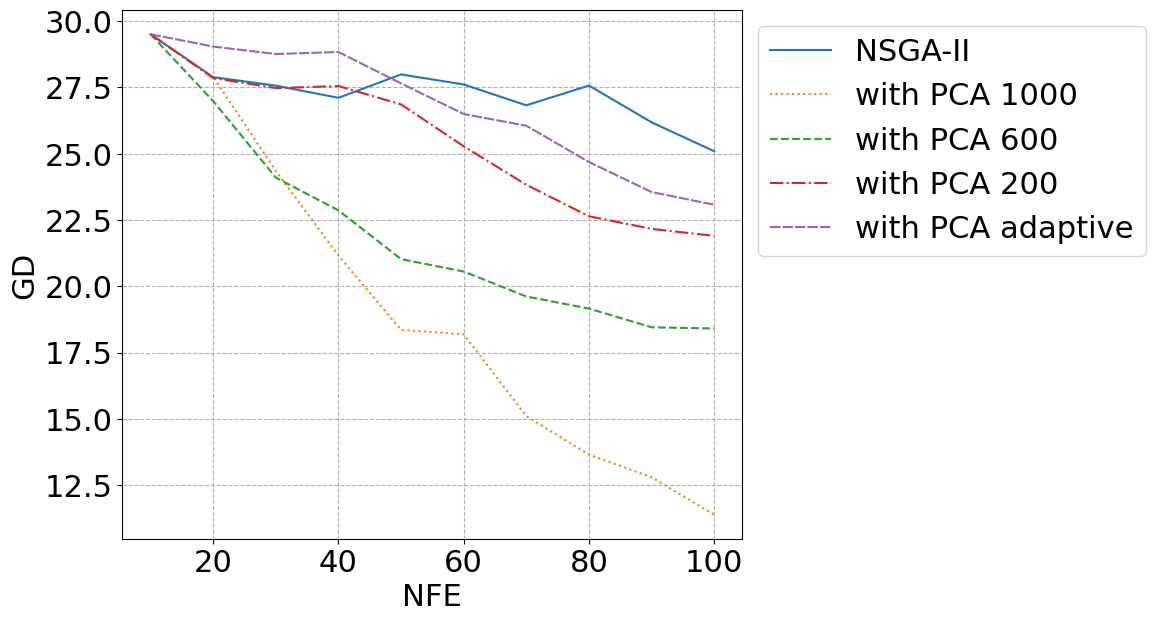

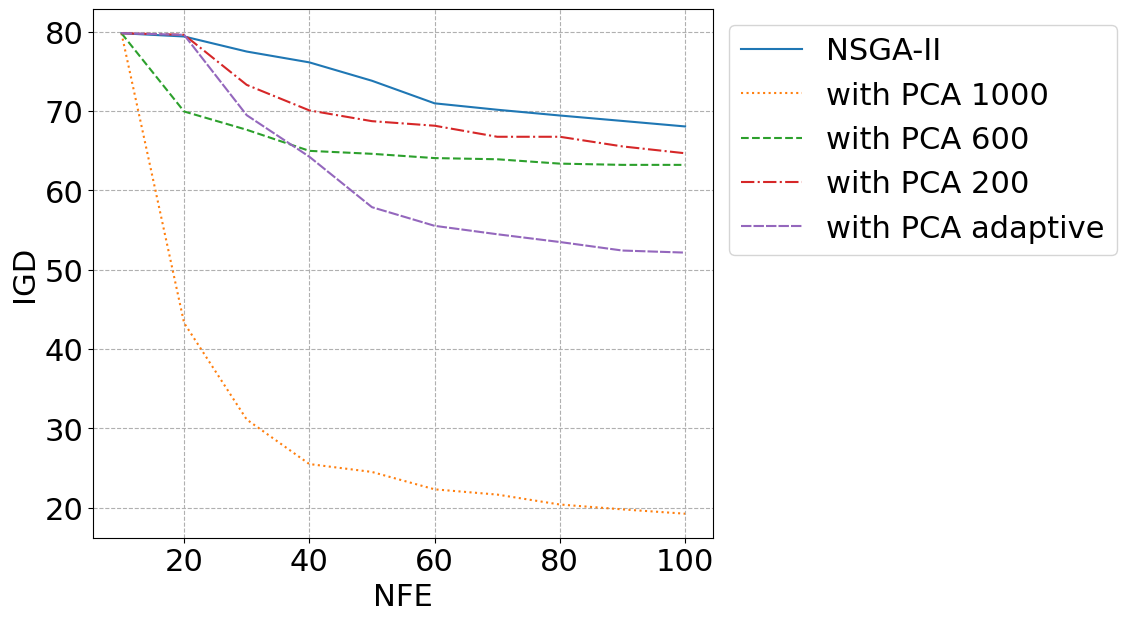

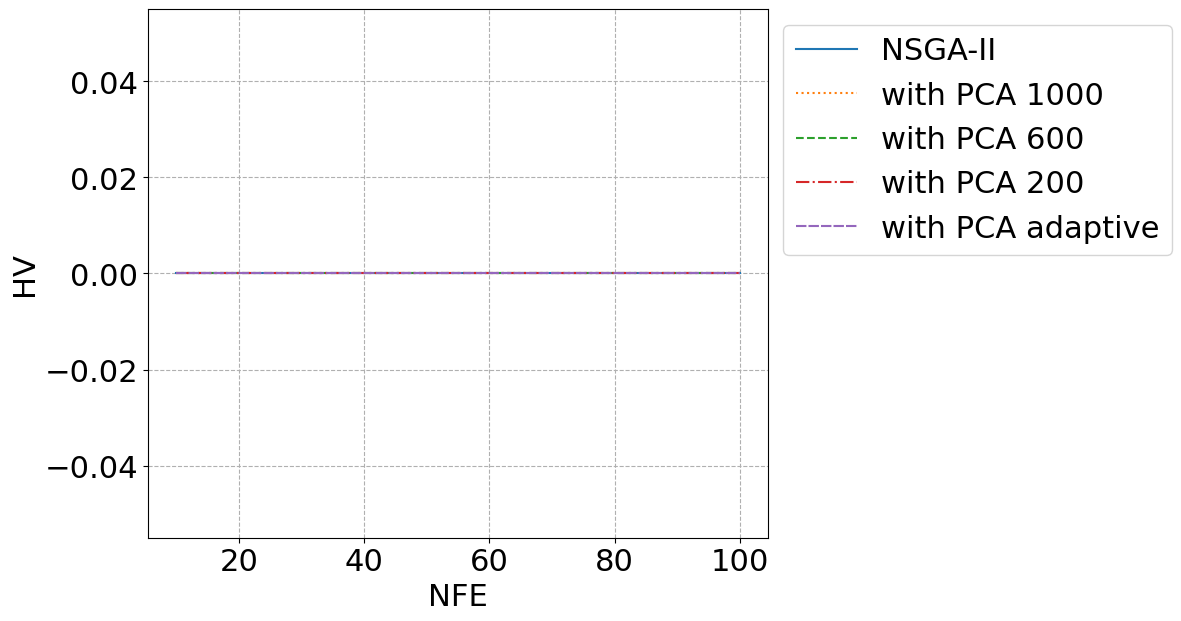

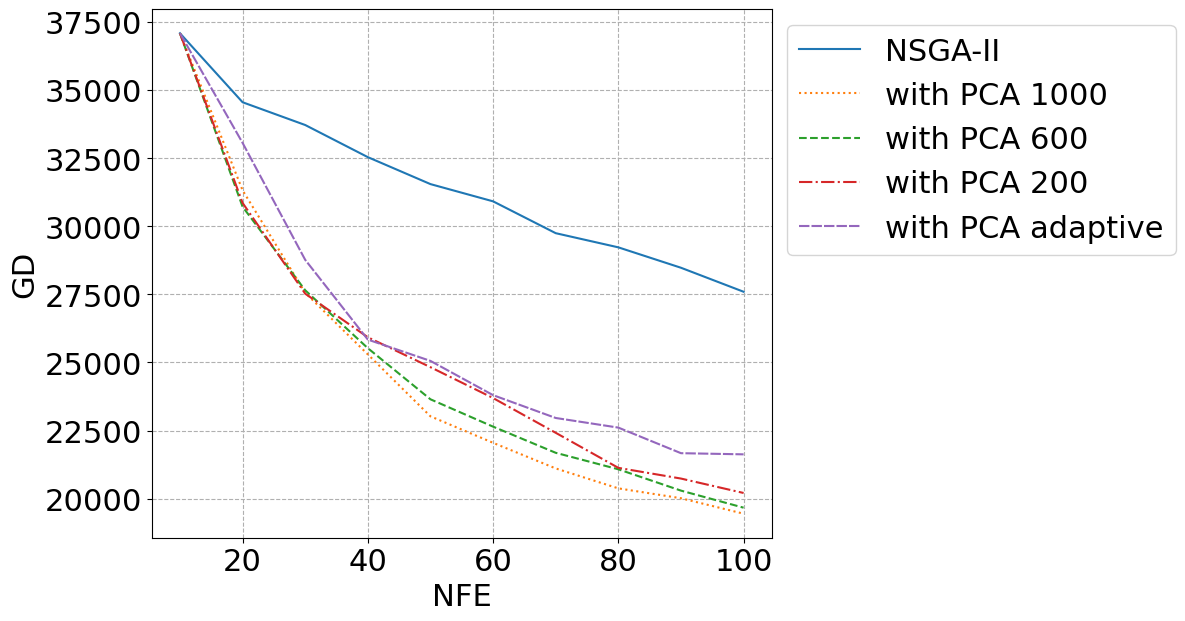

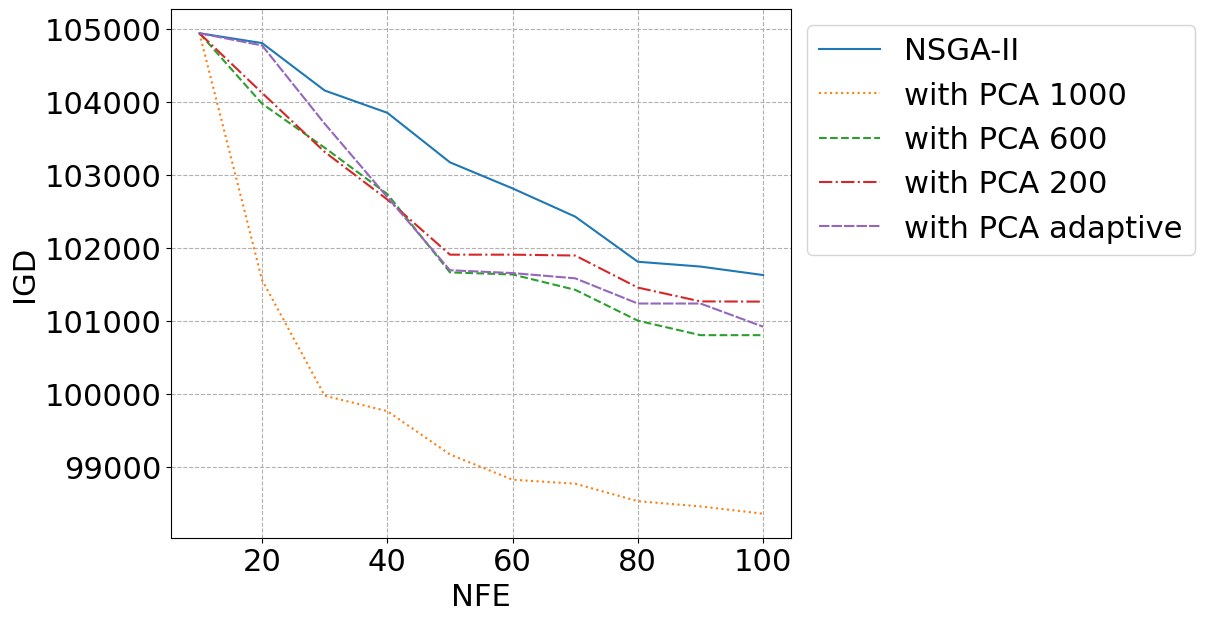

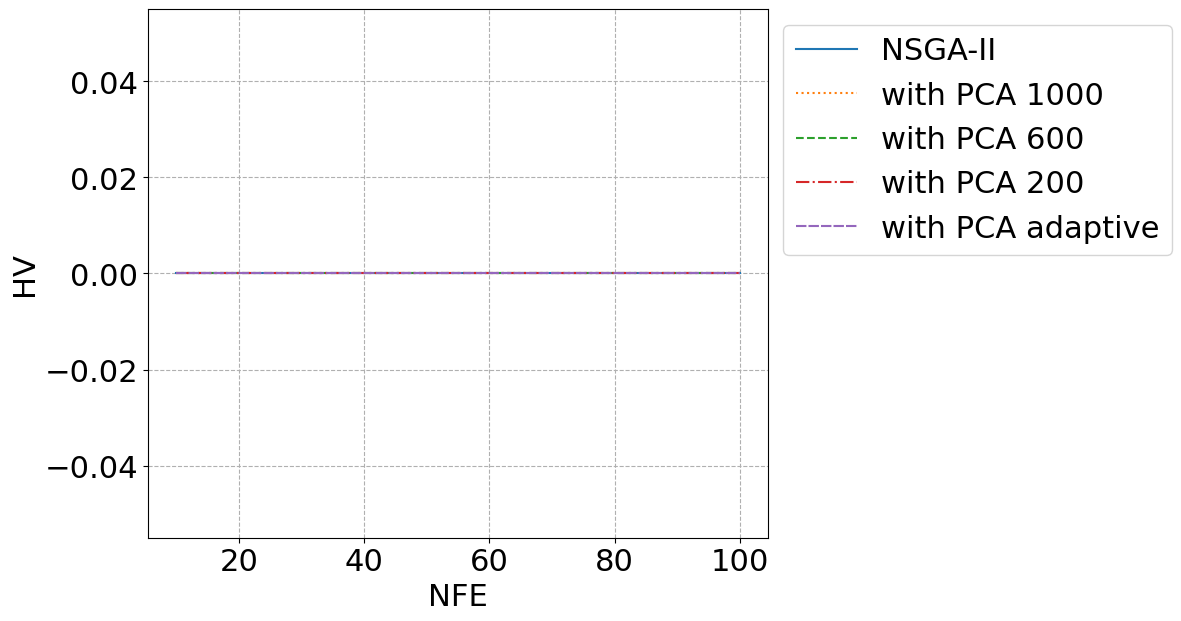

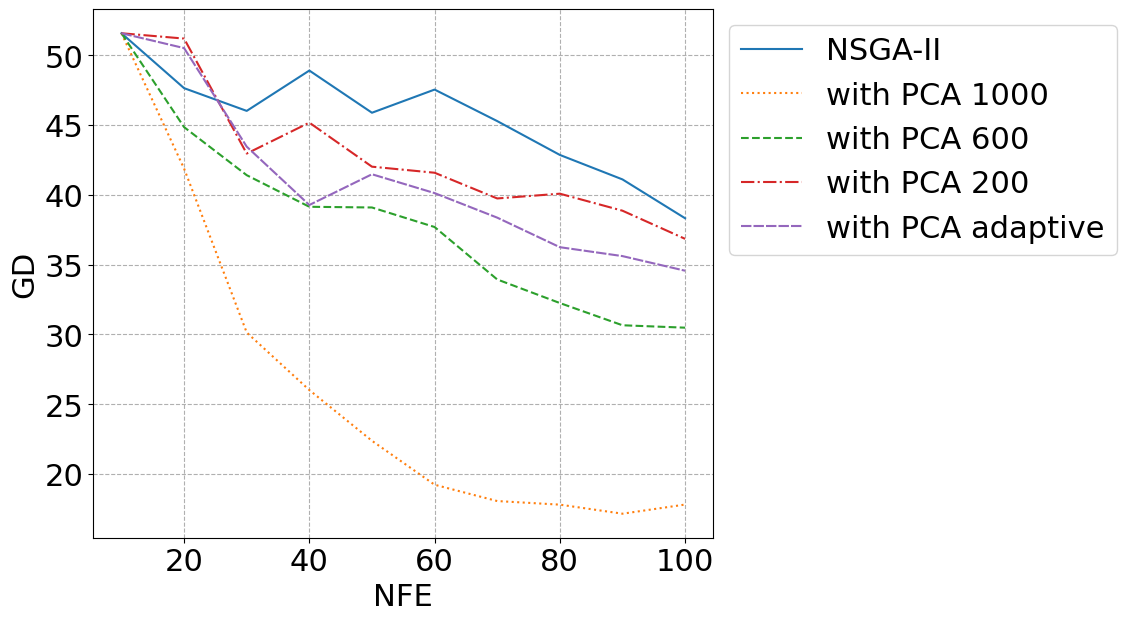

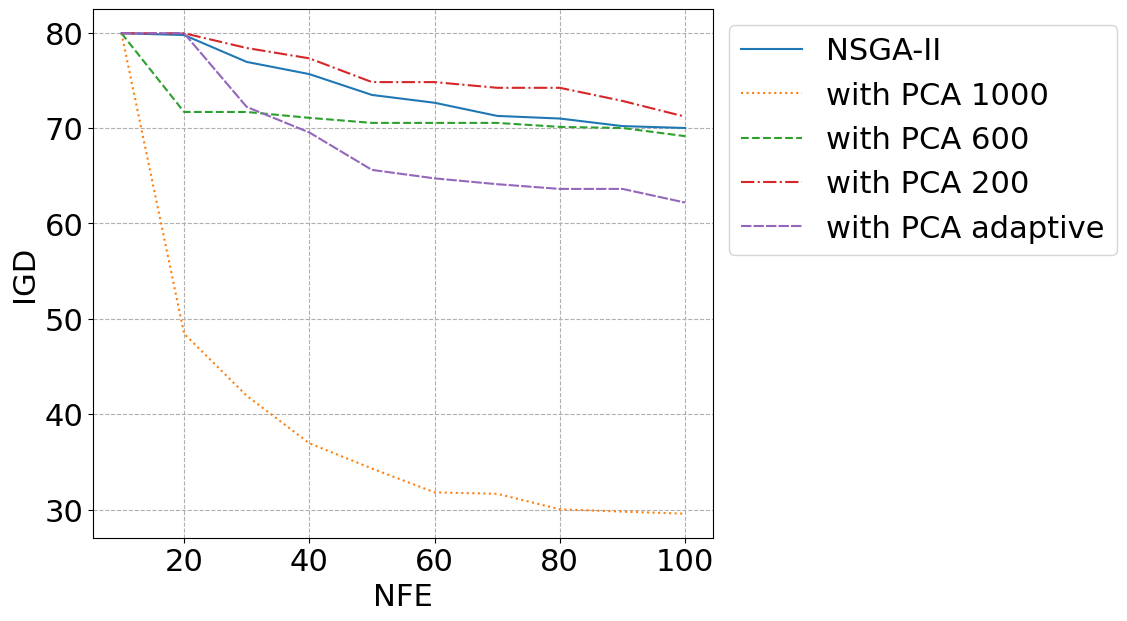

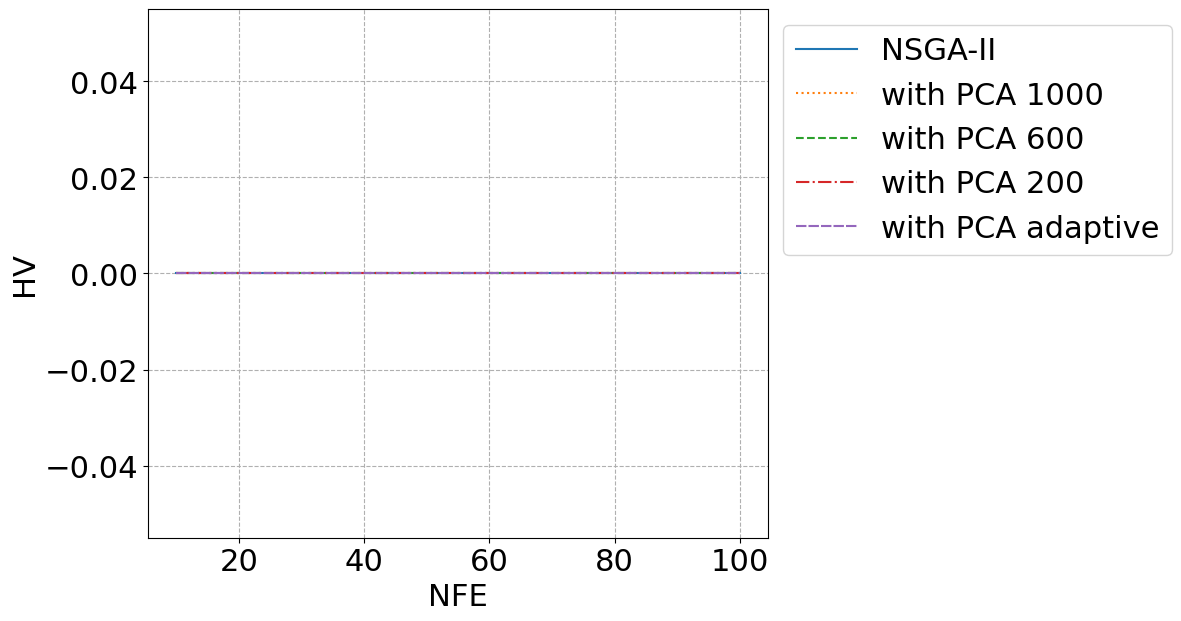

In [10]:
for pName in pNames:
    # 計算結果のパス（目的関数を追加。この下にアルゴリズム/試行
    base_path = '{}/{}/'.format(output_base_path, pName) #modified
    # 評価値の平均値を計算しファイルに保存する(1度だけ実行すればよい)
    makeMeanAccumDatas(base_path,nelems,aNames,ntrial)
    # 計算した平均値の読み込み
    meanAccumDatas = loadMeanAccumDatas(base_path, nelems,aNames)
    # 評価値の平均値の可視化
    fig = plot_accumDatas(meanAccumDatas,aNamesLabel, 'NFE', 'GenerationalDistance', 'NFE', 'GD', 'upper left', (1, 1))
    fig.savefig(base_path+"1000_compareGD.png", bbox_inches='tight')
    fig = plot_accumDatas(meanAccumDatas ,aNamesLabel, 'NFE', 'InvertedGenerationalDistance', 'NFE', 'IGD', 'upper left', (1, 1))
    fig.savefig(base_path+"1000_compareIGD.png", bbox_inches='tight')
    fig = plot_accumDatas(meanAccumDatas,aNamesLabel, 'NFE', 'Hypervolume', 'NFE', 'HV', 'upper left', (1, 1))
    fig.savefig(base_path+"1000_compareHV.png", bbox_inches='tight')

In [11]:
# リファレンスデータセット（パレートフロント・データセット）を読み込む
refset = lmp.loadReferenceSet(refset_path, nobj)
# リファレンスデータセットhistoryの可視化
fig = lmv.scatter2D_obj_history_with_referenceset(history, refset)

FileNotFoundError: [Errno 2] No such file or directory: '../pf/DTLZ4.2.pf'

In [ ]:
# history_pf.txtファイルの読み込み
trial = 0
aName = aNames[1]
history = lmp.HistoryData('{}/{}/{}/history_pf.txt'.format(base_path, 'nelem_adaptive-p10-NFE100-v1000'+"/"+aName, str(trial)))



In [ ]:
f = open('{}/{}/{}/history_pf.txt'.format(base_path, 'nelem_adaptive-p10-NFE100-v1000'+"/"+aName, str(trial)), "r", encoding="ms932", errors="", newline="" )
f = csv.reader(csv_file, delimiter=",", doublequote=True, lineterminator="\r\n", quotechar='"', skipinitialspace=True)


In [ ]:
dataset=pd.read_table('{}/{}/{}/history_pf.txt'.format(base_path, 'nelem_adaptive-p10-NFE100-v1000'+"/"+aName, str(trial)),sep=",")
dataset

In [ ]:
for pName in pNames:
    # 計算結果のパス（目的関数を追加。この下にアルゴリズム/試行
    base_path ='{}/{}/'.format(output_base_path, pName) #modified
    dataset=pd.read_table('{}/{}/{}/history_pf.txt'.format(base_path, 'nelem_adaptive-p10-NFE100-v1000'+"/"+aName, str(trial)),sep=",")

    fig = plt.figure(figsize=(8, 7), dpi=100)  # figure size
    plt.rcParams["font.size"] = 22  # whole font size
    
    ax = fig.add_subplot(1, 1, 1)
    ax.set_axisbelow(True)

    linestyle_gen = linestyle_generator()
    marker_gen = marker_generator()
    markersize_gen = markersize_generator()
    x = dataset["NFE"]
    y = dataset["mode"]
    plt.plot(x, y, label="number of pc",
                         linestyle=next(linestyle_gen),
                         marker=next(marker_gen),
                         markersize=next(markersize_gen))
    plt.grid(ls='--')
    loc = 'upper left'
    anchor = (1, 1)

    ax.legend(loc=loc, bbox_to_anchor=anchor)
    plt.yscale("log")

    plt.xlabel("NFE")
    plt.ylabel("mode")
    print(base_path)
    plt.savefig(base_path+'nelem_adaptive-p10-NFE100-v1000'+"/"+aName+"/"+ str(trial)
    +"pcanumDTLZ4.png", bbox_inches='tight')

    plt.show()



In [ ]:
base_path = '{}/{}/'.format(output_base_path, pName) #modified


In [ ]:
def scatter2D_obj_history_with_referenceset(history, referenceSet):
    """Draw 2-dimensional objective space by history with reference set

    It's colored by NFE value.

    Args:
        history (dataframe): Data frame of history

    Returns:
        Figure object
    """

    fig = plt.figure(figsize=(8, 7), dpi=100)  # figure size
    plt.rcParams["font.size"] = 22  # whole font size

    ax = fig.add_subplot(1, 1, 1)
    ax.set_axisbelow(True)

    cmap = plt.get_cmap('rainbow')

    nfes = history.getNFESet()

    for i in nfes:
        objs = history.getObjByNFE(i)
        cs = history.getNFEByNFE(i)
        sc = plt.scatter(objs.f0, objs.f1, s=10, c=cs, cmap=cmap,
                         vmin=0, vmax=history.getNumberOfEvaluations())

    """Plot reference set"""
    ref_s = referenceSet.sort_values('f0')
    plt.plot(ref_s.f0, ref_s.f1)
    plt.grid(ls='--')

    plt.xlabel('$f_1$')
    plt.ylabel('$f_2$')

    plt.colorbar(sc, label='NFE')

    plt.show()


In [ ]:
for pName in pNames:
    # リファレンスデータセットのファイル名を含むパス（DTLZ, WFGシリーズの場合）
    refset_path = '{}/{}.{}.pf'.format(refset_base_path, pName, str(nobj))
    # 計算結果のパス（目的関数を追加。この下にアルゴリズム/試行
    base_path = '{}/{}/'.format(output_base_path, pName) #modified
    # 計算結果のパス（目的関数を追加。この下にアルゴリズム/試行
    base_path = '{}/{}/'.format(output_base_path, pName) #modified
    # 評価値の平均値を計算しファイルに保存する(1度だけ実行すればよい)
    makeMeanAccumDatas(base_path,nelems,aNames,ntrial)
    # 計算した平均値の読み込み
    meanAccumDatas = loadMeanAccumDatas(base_path,nelems,aNames)
    # 評価値の平均値の可視化
    print(meanAccumDatas)

In [ ]:
for pName in pNames:
    # 計算結果のパス（目的関数を追加。この下にアルゴリズム/試行
    base_path = '{}/{}/'.format(output_base_path, pName) #modified
    # 評価値の平均値を計算しファイルに保存する(1度だけ実行すればよい)
    makeMeanAccumDatas(base_path,nelems,aNames,ntrial)
    # 計算した平均値の読み込み
    meanAccumDatas = loadMeanAccumDatas(base_path, nelems,aNames)
    # 評価値の平均値の可視化
    fig = plot_accumDatas(meanAccumDatas,aNamesLabel, 'NFE', 'GenerationalDistance', 'NFE', 'GD', 'upper left', (1, 1))
    fig.savefig(base_path+"1000_compareGD.png", bbox_inches='tight')
    fig = plot_accumDatas(meanAccumDatas ,aNamesLabel, 'NFE', 'InvertedGenerationalDistance', 'NFE', 'IGD', 'upper left', (1, 1))
    fig.savefig(base_path+"1000_compareIGD.png", bbox_inches='tight')
    fig = plot_accumDatas(meanAccumDatas,aNamesLabel, 'NFE', 'Hypervolume', 'NFE', 'HV', 'upper left', (1, 1))
    fig.savefig(base_path+"1000_compareHV.png", bbox_inches='tight')

In [ ]:
for pName in pNames:
    # 計算結果のパス（目的関数を追加。この下にアルゴリズム/試行
    base_path = '{}/{}/'.format(output_base_path, pName) #modified
    print(base_path)

In [ ]:
# history_pf.txtファイルの読み込み
for pName in pNames:
    # リファレンスデータセットのファイル名を含むパス（DTLZ, WFGシリーズの場合）
    refset_path = '{}/{}.{}D.pf'.format(refset_base_path, pName, str(nobj))
    # 計算結果のパス（目的関数を追加。この下にアルゴリズム/試行
    base_path = '{}/{}/'.format(output_base_path, pName) #modified
    print(base_path)
    trial = 0
    for aName in aNames:
        for nelem in nelems:
            print('{}/{}/{}/{}/history_pf.txt'.format(base_path,nelem ,aName, str(trial)))
            history = lmp.HistoryData('{}/{}/{}/{}/history_pf.txt'.format(base_path,nelem ,aName, str(trial)))
            # historyの可視化
            # リファレンスデータセット（パレートフロント・データセット）を読み込む
            refset = lmp.loadReferenceSet(refset_path, nobj)
            fig = lmv.scatter2D_obj_history_with_referenceset(history, refset)
            
            fig.savefig(base_path+"/"+nelem+"/"+aName, bbox_inches='tight')
           

In [ ]:
# 設計変数の並行座標プロット
fig = lmv.parallel_coordinates_var_history(history)
# 設計変数の履歴の可視化(変数のサブセットを可視化)
variable_ids = [i for i in range(2, 4)]
fig = lmv.scatter2D_var_history(history, variable_ids)
# 設計変数の履歴の可視化(全変数を可視化)
fig = lmv.scatter2D_var_history(history)